# WASP RL - Meeting 2 - Lab assignment on NAF  and SQL

In this lab we implement and experiment with NAF and SQL, both algorithms we learned about in the course and both can deal with continuous state **and** action spaces. Both algorithms employ deep neural networks for function approximation. To do this assignment, you will need to work with PyTorch, a popular framework for developing neural networks. When forming groups, make sure that at least one group member if comfortable with PyTorch and its most common tensor operations.

This notebook has been created specifically for this course and this session by *Finn Rietz* and *Johannes A. Stork*, we hope you enjoy the lab :)

We complete this lab as a group of three. All group members contributed equally.

    Willem Meijer (willem.meijer@liu.se)  
    Yikun Hou (yikun.hou@umu.se)  
    Yiran Wang (yiran.wang@liu.se)

In [2]:
# # install requirements if needed
# import sys
# !{sys.executable} -m pip install gym[classic_control]==0.26.2 numpy==1.23.0 matplotlib==3.1.2 
# !{sys.executable} -m pip install torch==1.12.0 torchaudio==0.12.0 torchvision==0.13.0 scipy==1.3.3

In [4]:
# !pip install gym"[classic_control]"==0.26.2

In [7]:
pip install numpy==1.23.0

  Using cached numpy-1.23.0-cp39-cp39-win_amd64.whl.metadata (2.2 kB)
Using cached numpy-1.23.0-cp39-cp39-win_amd64.whl (14.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
  You can safely remove it manually.


In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde
import random
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.optim import Adam

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")
print(f"torch device: {DEVICE}")

from buffer import ReplayBuffer
from utils import presample_env, transform_action, smooth, obs_transform, OUNoise, rbf_kernel2
from env_v2 import MultiGoalEnv
from network import MLP
from plotting import plot_loss, plot_reward

torch device: cpu


In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# NAF
We start with NAF. From the paper, we know that the value $V(\mathbf{x} | \theta)$, the action $\mathbf{\mu(x|}\theta)$, and the matrix entries $\mathbf{L(x}|\theta)$ are being approximated by neural networks. Its easiest to just have one a single neural network with multiple output heads for each quantity. As a first step, **adjust the code below so that the network outputs the desired values**. This involves making output layers for each quantity and implementing the equations for $Q(x,u)|\theta)$ and $A(x, u |\theta)$ in the forward pass of the neural network:
![NAF quantities](notebook_imgs/NAF_quantities.png)

In [3]:
class NAFNetwork(nn.Module):
    def __init__(self, state_size, action_size, layer_size):
        super(NAFNetwork, self).__init__()
        self.action_size = action_size

        self.fc_0 = nn.Linear(state_size, layer_size)
        self.fc_1 = nn.Linear(layer_size, layer_size)
        self.fc_2 = nn.Linear(layer_size, layer_size)
        
        # TODO: make output layers
        # HINT: The number of entries in a (not-strictly) lower-triangular n x n matrix is: n * (n + 1) / 2
        # HINT: These are just linear layers with the right number of outputs...
        self.mu_head = nn.Linear(layer_size, self.action_size)
        self.v_head =  nn.Linear(layer_size, 1)
        self.mat_head = nn.Linear(layer_size, int(self.action_size * (self.action_size + 1) / 2))

    def forward(self, state, action=None):
        """
        Forward pass of Normalized Advantage Function
        Returns the noisy exploration action, Q(s, a), V(s), and the greedy, non-noisy action
        """
        # get latent representation
        x = torch.relu(self.fc_0(state))
        x = torch.relu(self.fc_1(x))
        x = torch.relu(self.fc_2(x))
        
        # TODO predict the action mu, the value v and the matrix entries
        # HINT: Make use of the ouput heads we defined above
        greedy_action = self.mu_head(x)  # mu_head usage
        V = self.v_head(x)               # v_head usage
        entries = self.mat_head(x)       # mat_head usage

        greedy_action = greedy_action.unsqueeze(-1)
        
        # TODO: calculate P
        # HINT: create empty lower-triangular matrix as described in the paper
        L = torch.zeros((state.shape[0], self.action_size, self.action_size), device = DEVICE) # Initialize zero tensor (state.device)
        tril_indices = torch.tril_indices(row = self.action_size, col = self.action_size, offset = 0) # Lower triangular part of the matrix
        L[:, tril_indices[0], tril_indices[1]] = entries # Assigns values
        L.diagonal(dim1 = 1,dim2 = 2).exp_() # Extracts the main diagonal elements and replaces each element with its exponential (Ensure positive)
        P = L * L.transpose(2, 1) # Build P
        # if an action is given (during batch update), calculate Q
        Q = None
        if action is not None:
            # TODO: calculate Advantage:
            A = (-0.5 * torch.matmul(torch.matmul((action.unsqueeze(-1) - greedy_action).transpose(2, 1), P), (action.unsqueeze(-1) - greedy_action))).squeeze(-1)
            Q = A + V
            pass

        # add noise to the greedy action, for exploration in continuous action space
        # -----------
        # A - Gaussian
        # noise = torch.randn_like(greedy_action) * 0.1                          # Generate Gaussian noise
        # noisy_action = greedy_action.squeeze(-1) + noise.squeeze(-1)           # Add noise
        # -----------
        # B - Adaptive 
        c = 0.6 # Scale factor; larger c with larger noise
        dist = MultivariateNormal(greedy_action.squeeze(-1), c * torch.inverse(P)) 
        noisy_action = dist.sample()
        # -----------
        # Range limit
        noisy_action = torch.clamp(noisy_action, min = -1, max = 1)
        # print("noisy_action shape:", noisy_action.shape)
        return noisy_action, Q, V, greedy_action

Next, we make a class for the NAF agent, that will hold an instance of the above class for the neural network. The agent also implements an update method that updates the parameters of the neural network networka and a rollout method. Fortunately, the NAF update is straightforward, since it directly minimizes the TD error. **In the below cell, in the `update` method, compute the loss as described in the algorithm**. The update method alongside the rollout method essentially implement the entire NAF algorithm:
![NAF algorithm](notebook_imgs/NAF_algo.png)

In [4]:
class NAFAgent:
    def __init__(self, n_states, n_actions, buffer, net_size, gamma, tau, lr):
        """
        @param n_states: The dimensionality of the state space
        @param n_actions: The dimensionality of the action space
        @param buffer: An instance of a replay buffer
        @param net_size: The width of the NAF network layers
        @param gamma: The discount rate
        @param tau: The soft/polyak target network update rate
        @param lr: The learning rate
        """
        self.buffer = buffer
        self.loss_fn = nn.SmoothL1Loss()
        self.update_counter = 0
        self.GAMMA = gamma
        self.TAU = tau
        self.LR = lr
        self.loss_hist = []

        # main network
        self.naf_net = NAFNetwork(
            state_size=n_states,
            action_size=n_actions,
            layer_size=net_size,
        )
        self.naf_net.to(DEVICE)

        # target network
        self.target_net = NAFNetwork(
            state_size=n_states,
            action_size=n_actions,
            layer_size=net_size,
        )
        self.target_net.to(DEVICE)
        self.target_net.load_state_dict(self.naf_net.state_dict())

        self.optim = Adam(self.naf_net.parameters(), lr=self.LR)
        
    def rollout(self, env, episode, mode="train"):
        """
        Runs one episode and does a batch update after each step.
        """
        obs, info = env.reset()
        done = False
        truncated = False
        total_reward = 0

        while not (done or truncated):
            if mode == "train":
                action, _, _, _ = self.naf_net(torch.from_numpy(obs).unsqueeze(0).to(DEVICE).to(torch.float32))
            elif mode == "eval":
                _, _, _, action = self.naf_net(torch.from_numpy(obs).to(DEVICE).to(torch.float32))
            else:
                raise ValueError(f"Invalid mode 'mode' given!")
            
            action = transform_action(action.squeeze(0), env)
            
            new_obs, reward, done, truncated, info = env.step(action)
            total_reward += reward
            
            if mode == "train":
                self.buffer.add(obs, action, reward, new_obs, done)
                self.update()

            if done or truncated:
                print(f"Total reward {mode} episode {episode}: {total_reward}")
                return total_reward
            
            obs = new_obs

    def update(self):
        """
        Updates the neural network based on a batch of experiences sampled from the replay buffer.
        """
        if len(self.buffer) < self.buffer.batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample()
        self.optim.zero_grad()
        
        # TODO: compute the loss
        # HINT: Compute the Q prediction for the given states and actions
        # HINT: Compute the target values
        # --------------------- 
        
        with torch.no_grad():
            _, _, V_next, _ = self.target_net(next_states)      # Obtain V_next
        V_target = rewards + self.GAMMA * V_next * (1 - dones)  # Calculate target values
        _, Q_pred, _, _ = self.naf_net(states, actions)         # Calculate the current Q value prediction
        loss = self.loss_fn(Q_pred, V_target)                   # Calculate losses
        # ---------------------
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.naf_net.parameters(), 1) 
        self.optim.step()

        self.loss_hist.append(loss.item())
        self.update_counter += 1

        # polyak/soft target network udpate
        for target_param, current_param in zip(self.target_net.parameters(), self.naf_net.parameters()):
            target_param.data.copy_(self.TAU * current_param.data + (1.0 - self.TAU) * target_param.data)

Now, we just need a method that initializes the agent and runs the main trianing loop . **In the next cell, don't change anything**. You can play with the hyperparameters later, but when we highly recommend that you don't change them for now, since the ones we put for you definitly work!

In [5]:
def naf_algo(
        env,
        train_episodes=200,
        net_size=64,
        gamma=0.975,
        tau=0.0025,
        lr=0.001,
        batch_size=128,
        ): 
    
    buffer = ReplayBuffer(
        buffer_size=int(1e6),
        batch_size=batch_size,
        device=DEVICE,
    )
    
    agent = NAFAgent(
        env.observation_space.shape[0],
        env.action_space.shape[0],
        buffer,
        net_size,
        gamma,
        tau,
        lr
    )
    
    # populate replay buffer with 10k random transitions
    presample_env(env, agent.buffer, 10000)

    # main loop
    training_rewards = []
    eval_rewards = []
    eval_eps = []
    for episode in range(train_episodes):
        tr = agent.rollout(env, episode)
        training_rewards.append(tr)

        if episode % 5 == 0:
            er = agent.rollout(env, episode, mode="eval")
            eval_rewards.append(er)
            eval_eps.append(episode)
            
    plot_loss(agent.loss_hist)
    plot_reward(training_rewards, eval_rewards, eval_eps)
    
    return agent

# Testing NAF on Pendulum environment
Now, with all of this (partially boilerplate) code out of the way, its time to test our NAF agent. We use the [OpenAI Gym Pendulum environment](https://mgoulao.github.io/gym-docs/environments/classic_control/pendulum/), which is arguably one of the easiest, continuous action space environments. The agent should reach about -250 reward relatively quickly, if you've implemented everything correctly. There can still be quite some variation (i.e. between 0 and -700), depending on the random initialization of the pendulum...

Presampling done
Total reward train episode 0: -670.5878706591822
Total reward eval episode 0: -1359.2184829254536
Total reward train episode 1: -871.1925917466518
Total reward train episode 2: -1169.6274834720966
Total reward train episode 3: -1177.77339136549
Total reward train episode 4: -1245.2134962810655
Total reward train episode 5: -1309.223965614801
Total reward eval episode 5: -1680.8230842017222
Total reward train episode 6: -1338.8970408344185
Total reward train episode 7: -1685.2609157779232
Total reward train episode 8: -1421.0016724024724
Total reward train episode 9: -1112.4278977273739
Total reward train episode 10: -1236.5748515095368
Total reward eval episode 10: -1090.9993583261178
Total reward train episode 11: -1351.6893437034723
Total reward train episode 12: -1350.1492793861648
Total reward train episode 13: -1384.7383717417679
Total reward train episode 14: -1163.4854316308847
Total reward train episode 15: -1209.289972290496
Total reward eval episode 15: -1465

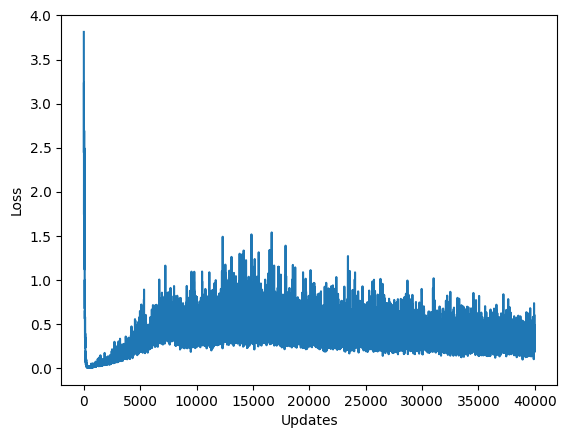

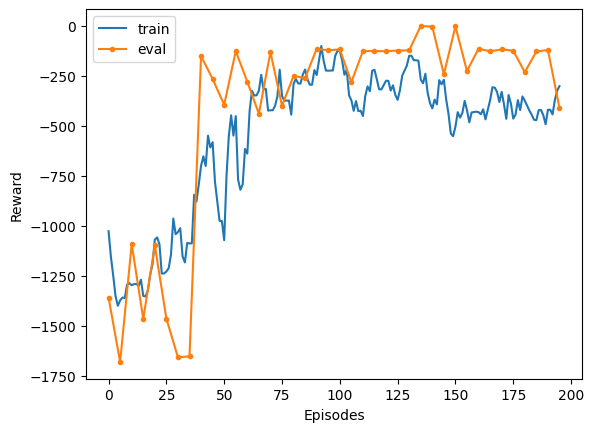

In [6]:
pendulum_env = gym.make("Pendulum-v1")
naf_agent = naf_algo(pendulum_env)

### Continue with the next part of the assignment only when your NAF implementation maintains between 0 and -700 reward on the pendulum environment!
Once the NAF agent reaches acceptable performance on the pendulum environment, explore the effect of exploration noise. In the NAF paper in section 8.2, the authors describe how to use the matrix $P$ from the advantage term for adaptive noise generation. Assuming you used simple Gaussian noise so far, go back to the the forward pass of the neural network and implement adaptive noise instead. Do you observe a considerable difference on the Pendulum environment when using adaptive noise?

<span style="color:blue">Yes, there is a considerable difference on the pendulum environment (especially in the reward curve) when using adaptive noise.
Since we use adaptive method (with range limit) as the baseline, adding the range limit to the Gaussian noise action can reduce the difference.</span>

<span style="color:blue">Note the scale factor `c` also affect the performance.</span>

<span style="color:red">Range Limit</span> : `noisy_action = torch.clamp(noisy_action, min = -1, max = 1)` 

# Multigoal environment
Now, we turn to a more interesting but still toy example, the "multigoal" environment introduced in the Soft Q-Learning paper. This environment features four goals (the stars in the below image) the agent can navigate to. The observation is the current position, the actions are 2D velocities to apply to the agent. The agent always starts at the center (plus some small random offset). The reward is the distance to the closest goal plus a small cost proportional to the squarred action sum. Consider below the plot of the reward function evaluated at a fine grid of locations for further intuition:
![multigoal env](notebook_imgs/multigoal-env-reward.png)

# TASK: Draw on a paper a [contour plot](https://se.mathworks.com/help/examples/graphics/win64/DisplayContourLabelsExample_01.png) of what you think NAF's value function will look like. Keep the paper for later comparison with the actual value function. 

...

# TASK: Also draw the trajectories that you think NAF's policy will generate. Keep the paper for later comparison with actual trajectories generated by the policy.

...

C:\Users\yirwa29\.conda\envs\RL\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Presampling done
Total reward train episode 0: -56.62532387281095
Total reward eval episode 0: -21.195495314637693
Total reward train episode 1: -69.15835395342484
Total reward train episode 2: -55.55650309848596
Total reward train episode 3: -61.36298993641166
Total reward train episode 4: -64.9694154742329
Total reward train episode 5: -60.89848325517727
Total reward eval episode 5: -11.553777869382854
Total reward train episode 6: -52.59596892660809
Total reward train episode 7: -65.52442657599309
Total reward train episode 8: -62.77783215448521
Total reward train episode 9: -52.06870648777121
Total reward train episode 10: -54.16767214943643
Total reward eval episode 10: -4.874817673735624
Total reward train episode 11: -56.93296212335061
Total reward train episode 12: -59.236748943229266
Total reward train episode 13: -56.149414612411874
Total reward train episode 14: -50.16230942598539
Total reward train episode 15: -57.82216897856657
Total reward eval episode 15: -5.423737570569

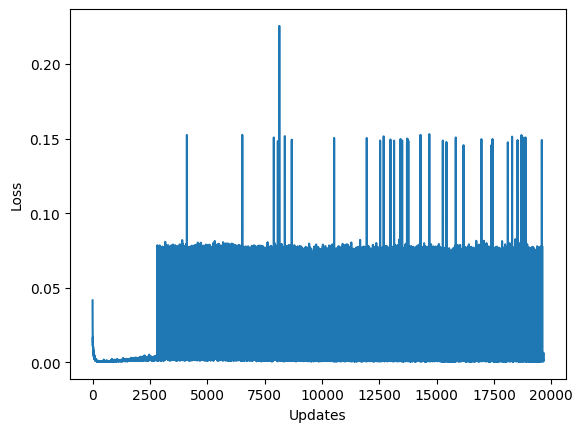

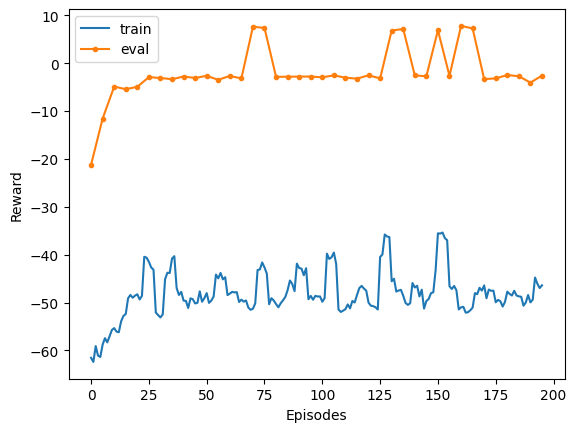

In [7]:
multigoal_env = MultiGoalEnv()
naf_agent = naf_algo(multigoal_env)

# Visualizing the value function
In addition to the the loss plot and reward plot above, it can be helpfull to visualize the learned value function and or policy, to understand better what the agent learned. This is often straightforward in 2D environments, since a small 2D grid is still managable in terms of compute. As such, **visualize the value function learned by the NAF agent on the multigoal environment**. Does NAF's learned value function look similar to what you drew on the paper? Can you explain why the learned value function looks the way it does?

<span style="color:blue">Yes; The value function map is not completely symmetrical. It may has several reasons. For example, the initialization of the neural network, the initialization of the replay buffer, optimization noise, the exploration noise in greedy action and so on.</span>

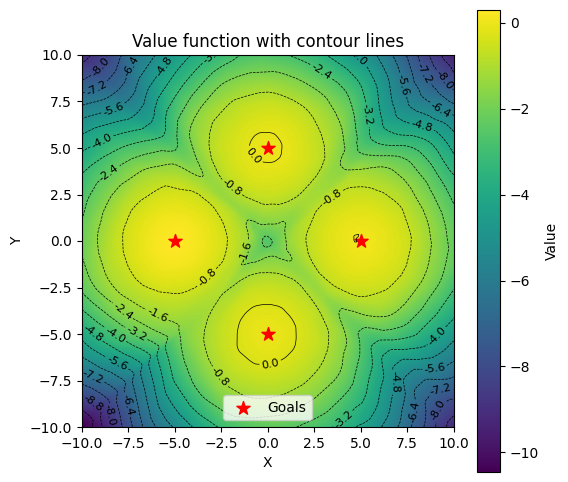

In [8]:
# YOUR CODE HERE
def plot_value(agent, env, grid_size = 200):
    # Grid boundaries
    x_min, x_max = env.xlim
    y_min, y_max = env.ylim
    x_vals = np.linspace(x_min, x_max, grid_size)
    y_vals = np.linspace(y_min, y_max, grid_size)

    # Initialize and update the value map
    value_map = np.zeros((grid_size, grid_size))   
    for i, x in enumerate(x_vals):
        for j, y in enumerate(y_vals):
            state = torch.tensor([[x, y]], dtype=torch.float32).to(DEVICE)
            # Obtain and store the value
            with torch.no_grad():
                _, _, V, _ = agent.naf_net(state)
            value_map[i, j] = V.item()

    # Plot value map (with contour lines)
    plt.figure(figsize = (6, 6))
    heatmap = plt.imshow(value_map, extent = (x_min, x_max, y_min, y_max), origin = 'lower', cmap = 'viridis')
    contours = plt.contour(x_vals, y_vals, value_map.T, levels = 16, linewidths = 0.5, colors = 'black')
    plt.clabel(contours, inline = True, fontsize = 8, fmt = '%1.1f')  # Label contour lines
    plt.colorbar(heatmap, label = "Value")
    plt.scatter(env.goal_positions[:, 0], env.goal_positions[:, 1], c = 'red', marker = "*", s = 100, label="Goals")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Value function with contour lines")
    plt.legend()
    plt.show()

# Visualize the value function (No n eed to re-train)
# multigoal_env = MultiGoalEnv()
# naf_agent = naf_algo(multigoal_env)
plot_value(naf_agent, multigoal_env)

# Visualizing the Q-function
Also plot the Q-function NAF learned for the environment state [0, 0], i.e. with the agent placed in the middle of the environment. Does the Q-function match the value function?

<span style="color:blue">If the advantage function equals to zero, the Q-function perfectly matchs the value function since `Q = V + A (A = 0)`. However, generally, `A` will be non-zero for actions because it cevaluates the “relative benefit” of an action in the current state compared to the average expected return represented by `V`. </span>

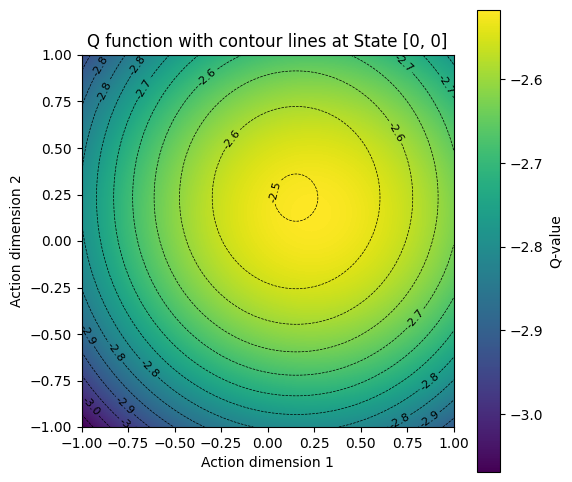

In [9]:
# YOUR CODE HERE
def plot_q(agent, env, center_state=[0, 0], grid_size = 200):
    # Grid boundaries
    action_min, action_max = env.action_space.low[0], env.action_space.high[0]
    action_vals = np.linspace(action_min, action_max, grid_size)

    # Initialize and update the Q map
    q_map = np.zeros((grid_size, grid_size))
    state = torch.tensor([center_state], dtype = torch.float32).to(DEVICE)
    for i, action_x in enumerate(action_vals):
        for j, action_y in enumerate(action_vals):
            action = torch.tensor([[action_x, action_y]], dtype = torch.float32).to(DEVICE)

            # Obtain and store the Q value
            with torch.no_grad():
                _, Q, _, _ = agent.naf_net(state, action)
            q_map[i, j] = Q.item()

    # Plot Q map (with contour lines)
    plt.figure(figsize = (6, 6))
    heatmap = plt.imshow(q_map, extent = (action_min, action_max, action_min, action_max), origin = 'lower', cmap = 'viridis')
    contours = plt.contour(action_vals, action_vals, q_map.T, levels = 16, linewidths = 0.5, colors = 'black')
    plt.clabel(contours, inline = True, fontsize = 8, fmt = '%1.1f')
    plt.colorbar(heatmap, label = "Q-value")
    plt.xlabel("Action dimension 1")
    plt.ylabel("Action dimension 2")
    plt.title(f"Q function with contour lines at State {center_state}")
    plt.show()

# Visualize the Q function (No need to re-train)
# multigoal_env = MultiGoalEnv()
# naf_agent = naf_algo(multigoal_env)
plot_q(naf_agent, multigoal_env)

# Visualizing trajectories
In addition to the value function, we can inspect the trajectories generated by the policy. **Collect, plot and analyze some (10 - 50) trajectories from the policy**. Are the agent's trajectory similar to what you drew on the paper? Explain the result.

<span style="color:blue">Yes; In the multi-goal environment, the agent is trying to reach one of four symmetrically placed goals. An optimal strategy is to go to an goal with the maximum return. With the exploration, the randomness leads various trajectories (see the first block below). On the contrary, disabling reset noise limits the agent’s exploration of the environment (see the second block below). In this case, only one goal is reached (50 trajectories were collected). This makes sense, since the value map is not completely symmetrical.

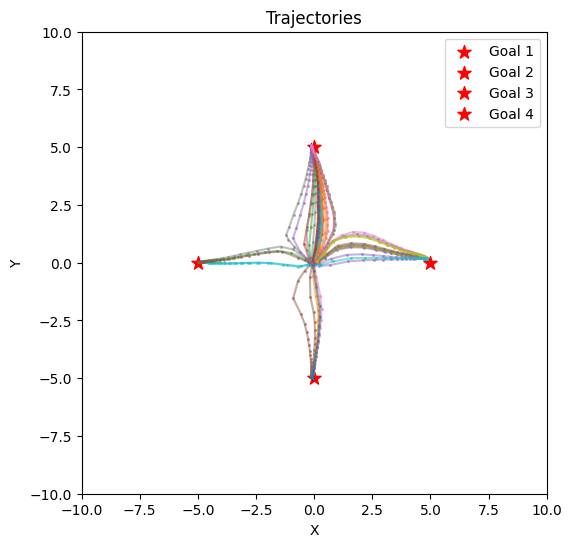

In [12]:
# YOUR CODE HERE
def plot_trajectories(agent, env, num_trajectories = 50, max_steps = 200):
    # num_trajectories: Number of trajectories to collect and plot
    # max_steps: Maximum number of steps per trajectory (Not necessary; Used to avoid infinite loop)
    
    trajectories = []
    for _ in range(num_trajectories):
        # Initialize trajectory with the starting state
        state, _ = env.reset()
        trajectory = [state]
        done = False
        truncated = False

        # For loop: Avoid infinite loop
        # for _ in range(max_steps): 
        # Alternative while loop: No infinite obsevered
        while not done and not truncated:
            # Action
            _, _, _, action = agent.naf_net(torch.tensor(state, dtype = torch.float32).unsqueeze(0).to(DEVICE))
            action = action.cpu().detach().numpy().flatten()

            # Step
            next_state, _, done, truncated, _ = env.step(action)
            trajectory.append(next_state)
            if done or truncated:
                break
            state = next_state
        
        # Record trajectories
        trajectories.append(np.array(trajectory))

    # Plot
    plt.figure(figsize = (6, 6))
    # Goal positions
    for idx, goal_position in enumerate(env.goal_positions):
        plt.scatter(*goal_position, color = 'red', s = 100, marker = '*', label = f"Goal {idx + 1}")
    
    # Trajectories
    for trajectory in trajectories:
        plt.plot(trajectory[:, 0], trajectory[:, 1], marker = 'o', markersize = 1.2, alpha = 0.5)

    plt.xlim(env.xlim)
    plt.ylim(env.ylim)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Trajectories")
    plt.legend(loc = "best")
    plt.show()

# Collect and plot trajectories (No need to re-train; with exploration)
# multigoal_env = MultiGoalEnv()
plot_trajectories(naf_agent, multigoal_env)

Presampling done
Total reward train episode 0: -57.425914264799445
Total reward eval episode 0: -29.84088031054658
Total reward train episode 1: -69.4007082914935
Total reward train episode 2: -84.17771084043484
Total reward train episode 3: -66.31770273891198
Total reward train episode 4: -55.437833707808124
Total reward train episode 5: -43.33089663801203
Total reward eval episode 5: -12.021401666701209
Total reward train episode 6: -51.96917261179604
Total reward train episode 7: -62.49564293306148
Total reward train episode 8: -59.89980968611819
Total reward train episode 9: -70.03162892902797
Total reward train episode 10: -55.35792943648172
Total reward eval episode 10: -13.107674798005577
Total reward train episode 11: -54.42855220988249
Total reward train episode 12: -63.86744672623461
Total reward train episode 13: -40.699230834872246
Total reward train episode 14: -55.257008834056535
Total reward train episode 15: -57.861868504875375
Total reward eval episode 15: -5.738809555

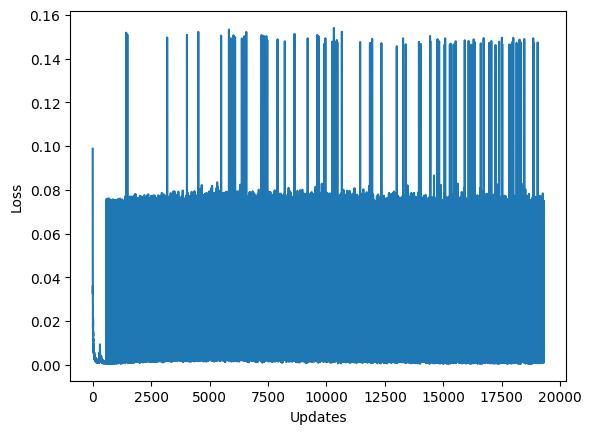

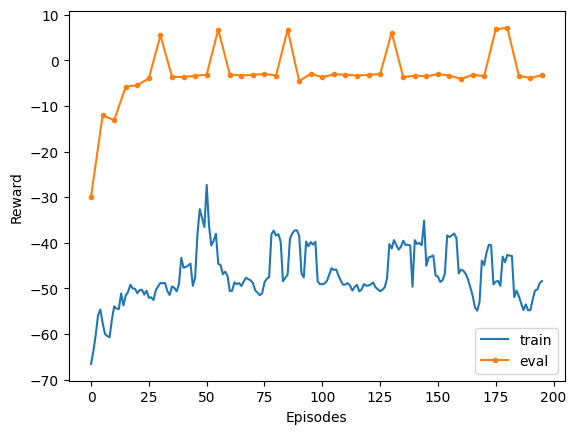

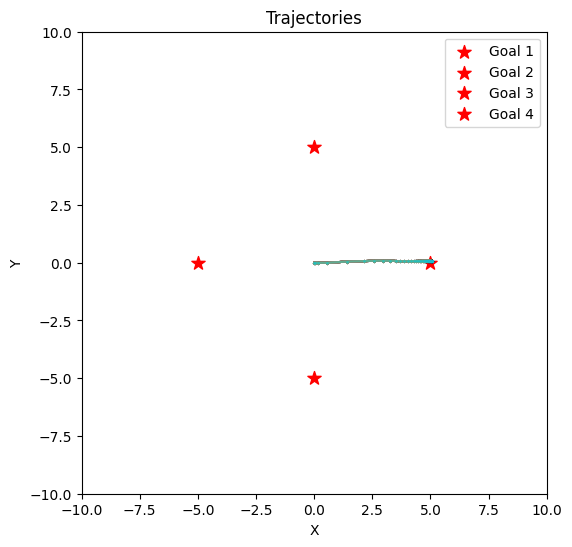

In [13]:
# Collect and plot trajectories (Need to re-train; Without exploration)
multigoal_env = MultiGoalEnv()
multigoal_env.init_sigma = 0.0  # disable reset noise, only used to help exploration during learning...
naf_agent = naf_algo(multigoal_env)
plot_trajectories(naf_agent, multigoal_env)

# Soft Q-Learning


We now turn to the second algorithm we learned about that can deal with continuous state and action spaces: Soft Q-learning (SQL). SQL is based on two neural networks, one for the $Q$-function and one for the policy. These are plain MLPs, hence this time you don't have to implement the neural network. However, you must initialize these networks with the correct input and output sizes. Thus, **in the `init` method in the next cell, set the `q_in_size`, `q_out_size`, `asvgd_noise_size`, `pi_in_size`, and `pi_out_size` variables**. These are passed to the respective neural networks initalizations.

Further, you will implement the update of the $Q$-function approximating neural network. This is relatively straightforward and based on the TD-error. **In the next cell, in the `td_update` method, calculate the loss for the $Q$-approximating network**. For this, you need to implement and consider the following equations. The soft value function:

![sql_vsoft](notebook_imgs/SQL_v_soft.png)

The soft value function's empirical estimate:

![sql_empirical_vsoft](notebook_imgs/SQL_empirical_v_soft.png)

And the minimization objective:

![sql_JQ](notebook_imgs/SQL_jq.png)

Note, that $\hat{Q}^{\bar\theta}_{\text{soft}} = r_t + \gamma \mathbb{E}_{s_{t+1}\sim p_s}[ V^{\bar\theta}_{\text{soft}}(s_{t+1}) ]$ and that $\bar\theta$ refers to the target network parameter.

We implement the update of the policy network for you, because itrelies on a method not covered in the course, the Amortized Stein Variational Gradient Descent (ASVGD). ASVGD has gained increasing popularity in SOTA research and provides an interesting alternative to sampling methods like Markov Chain Monte Carlo or Metropolis Hastings. ASVGD moves a set of random particles such that, after convergence, they act like samples from the distribution of interest, and only requires access to the unnormalized density. You can take a look how this is implemented and how it updates the policy network in the `asvgd_update` method. If you are interested, we encourage you to take a look at the official [project website](https://www.cs.utexas.edu/~qlearning/project.html?p=svgd).

In [ ]:
class SQLAgent:
    """
    SQL agent, https://arxiv.org/pdf/1702.08165.pdf
    """
    def __init__(self,
                 n_states,
                 n_actions,
                 buffer,
                 net_size,
                 gamma,
                 q_lr,
                 asvgd_lr,
                 hard_freq,
                 reward_scale,
                 n_particles,
                 sampler_act_fun=torch.tanh,
                 particle_scale=10.0,
                 bandwidth_scale=1
                 ):
        """
        @param n_states: The dimensionality of the state space
        @param n_actions: The dimensionality of the action space
        @param buffer: An instance of a replay buffer
        @param net_size: The width of the NAF network layers
        @param gamma: The discount rate
        @param q_lr: The learning rate for the q network
        @param asvgd_lr: The learnign rate for the policy network
        @param hard_freq: The hard update frequency of the q target network
        @param reward_scale: The scale of the reward signal
        @param n_particles: The number of particles used by ASVGD
        @param sampler_act_fun: The activation function used by the sampling network
        @param particle_scale: The scale of the particles noise for SVGD sampler
        """
        self.n_states = n_states
        self.n_actions = n_actions
        self.buffer = buffer
        # self.loss_fn = nn.MSELoss(reduction="mean")
        self.loss_fn = nn.SmoothL1Loss(reduction="mean")
        self.q_update_counter = 0
        self.GAMMA = gamma
        self.HARD_FREQ = hard_freq
        self.loss_hist = []
        self.svgd_loss_hist = []
        self.sample_diversity_hist = []
        self.reward_scale = reward_scale
        self.noise_gen = OUNoise(n_actions)
        self.n_particles = n_particles
        self.particle_scale = particle_scale
        self.bandwidth_scale = bandwidth_scale
        
        #  TODO: set these to the right values (these are all integers...)
        # ---------------------
        q_in_size = None
        q_out_size = None
        asvgd_noise_size = None
        pi_in_size = None
        pi_out_size = None
        # ---------------------

        # Q network
        self.q_net = MLP(
            in_size=q_in_size,
            out_size=q_out_size,
            layer_size=net_size,
        ).to(DEVICE)

        # target Q network
        self.target_q_net = MLP(
            in_size=q_in_size,
            out_size=q_out_size,
            layer_size=net_size,
        ).to(DEVICE)
        self.target_q_net.to(DEVICE)
        self.target_q_net.load_state_dict(self.q_net.state_dict())

        # policy sampling network
        self.pi_net = MLP(
            in_size=pi_in_size,
            out_size=pi_out_size,
            layer_size=net_size,
            act_fun=sampler_act_fun
        ).to(DEVICE)
        self.asvgd_noise_size = asvgd_noise_size

        self.q_optim = Adam(self.q_net.parameters(), lr=q_lr, weight_decay=0.01)
        self.asvgd_optim = Adam(self.pi_net.parameters(), lr=asvgd_lr)

    def td_update(self):
        """
        Updates the Q network based on a batch of experiences drawn uniformly from the replay buffer
        """
        if len(self.buffer.memory) < self.buffer.batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample()
        self.q_optim.zero_grad()

        # predict q for batch
        q = self.q_net.forward(torch.cat((states, actions), dim=1))

        with torch.no_grad():
            # TODO, calculate the 'target' aka 'desired' value J_Q(\theta), so that we can minimize the loss 
            # between q and the target
            # ---------------------
            
            
            
            
            target = None
            
            
            
            
            # ---------------------
        
        
        loss = self.loss_fn(q, target)
        loss.backward()
        self.q_optim.step()
        self.loss_hist.append(loss.item())

        self.q_update_counter += 1

        # hard target network update
        if self.q_update_counter % self.HARD_FREQ == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
            
    def act(self, state):
        """
        Helper function that constructs the input to the policy network.
        This is done slightly differently depending on on the shape of the state tensor.
        """
        if state.shape[0] == 1:
            # environment interaction
            zeta = torch.rand(self.n_particles, self.asvgd_noise_size).to(DEVICE)
            state = state.repeat(self.n_particles, 1)
            inp = torch.cat((state, zeta), dim=1)
        else:
            # batch update
            zeta = torch.rand(state.shape[0], self.n_particles, self.asvgd_noise_size).to(DEVICE)
            state = state.repeat(self.n_particles, 1, 1).movedim(1, 0)
            inp = torch.cat((state, zeta), dim=2)

        action = self.pi_net.forward(inp.to(torch.float32))

        return action
    
    def rollout(self, env, episode, mode="train"):
        """
        Runs one episode and does a batch update after each step.
        """
        obs, info = env.reset()
        done = False
        truncated = False
        total_reward = 0

        while not (done or truncated):
            a = self.act(torch.from_numpy(obs).unsqueeze(0).to(torch.float32).to(DEVICE))
            o_stack = obs_transform(torch.from_numpy(obs).unsqueeze(0), self.n_particles).to(torch.float32).to(DEVICE)
            q = self.q_net.forward(torch.cat((o_stack, a), dim=1))
            ind = torch.argmax(q)
            action = a[ind]

            if mode == "train":
                action += torch.from_numpy(self.noise_gen.sample()).to(DEVICE)

            action = transform_action(action, env)
            new_obs, reward, done, truncated, info = env.step(action)
            total_reward += reward

            if mode == "train":
                self.buffer.add(obs, action, reward, new_obs, done)
                self.td_update()
                self.asvgd_update()

            if done or truncated:
                print(f"Total reward {mode} episode {episode}: {total_reward}")
                return total_reward

            obs = new_obs

    def asvgd_update(self):
        """
        Updates the policy network using the ASVGD method on a batch of experiences drawn uniformly from the 
        replay buffer.
        """
        if len(self.buffer.memory) < self.buffer.batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample()

        # as described in the appendix of SQL paper, we need two sets of actions
        actions = self.act(states)
        assert actions.shape == (states.shape[0], self.n_particles, self.n_actions)
        
        fixed_actions = self.act(states)
        fixed_actions = fixed_actions.detach()
        fixed_actions.requires_grad = True

        # just for analysis, compute diversity of samples
        with torch.no_grad():
                pairwise_dists = torch.cdist(actions, fixed_actions, p=2)
                diversity_score = torch.mean(torch.exp(-pairwise_dists))
                self.sample_diversity_hist.append(diversity_score.item())

        # target for sampler is q, aka unnormalized policy density, thanks to maximum entropy framework
        state_stack = obs_transform(states, self.n_particles).to(DEVICE)
        asvgd_target = self.q_net(torch.cat((state_stack, fixed_actions), dim=2))
        log_p = asvgd_target

        grad_log_p = torch.autograd.grad(log_p.sum().to(DEVICE), fixed_actions.to(DEVICE))[0]
        grad_log_p = grad_log_p.unsqueeze(1)

        kappa, kappa_grad = rbf_kernel2(actions, fixed_actions, h_scale=self.bandwidth_scale)
        
        # eq 13 in paper, stein gradient
        # actions_grad = (1/self.n_particles) * torch.sum(kappa * grad_log_p + kappa_grad, dim=1)
        actions_grad = (1/self.n_particles) * torch.mean(kappa * grad_log_p + kappa_grad, dim=1)  # this is a lot better!
        actions_grad.to(DEVICE)
        # print("actions_grad.shape", actions_grad.shape, "actions.shape", actions.shape)
        self.svgd_loss_hist.append(actions_grad.sum(dim=-1).sum(dim=1).mean(dim=0).item())

        self.asvgd_optim.zero_grad()
        torch.autograd.backward(-actions, grad_tensors=actions_grad)  # this implements eq 14, chain rule backprop
        self.asvgd_optim.step()

With the update methods taken care of, as before, the only thing that is missing is the main loop. Also as before, we high suggest you don't change any of the hyperparameters until your SQL implementation is working.

In [ ]:
def sql_algo(
        env, 
        reward_scale=10, 
        n_particles=128, 
        train_episodes=200,
        batch_size=64,
        net_size=128,
        gamma=0.99,
        q_lr=0.001,
        pi_lr=0.0001,
        hard_freq=1000,
        particle_scale=10,
        bandwidth_scale=1,
        ):
    
    buffer = ReplayBuffer(
        buffer_size=int(1e6),
        batch_size=batch_size,
        device=DEVICE,
    )
    
    agent = SQLAgent(
        env.observation_space.shape[0],
        env.action_space.shape[0],
        buffer,
        net_size,
        gamma,
        q_lr,
        pi_lr,
        hard_freq,
        reward_scale,
        n_particles,
        particle_scale=particle_scale,
        bandwidth_scale=bandwidth_scale
    )
    
    # populate replay buffer with 10k random transitions
    presample_env(env, agent.buffer, 10000)

    # main loop
    training_rewards = []
    eval_rewards = []
    eval_eps = []
    for episode in range(train_episodes):
        print(f"Episode {episode}...\r", end="")      
        tr = agent.rollout(env, episode)
        training_rewards.append(tr)

        if episode % 5 == 0:
            er = agent.rollout(env, episode, mode="eval")
            eval_rewards.append(er)
            eval_eps.append(episode)
    
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    plot_loss(agent.loss_hist, ax=axs[0])
    axs[0].set_title("Training Loss Q")
    plot_loss(agent.svgd_loss_hist, ax=axs[1])
    axs[1].set_title("Training Loss SVGD")
    plot_loss(agent.sample_diversity_hist, ax=axs[2])
    axs[2].set_title("Sampler diversity")
    plot_reward(training_rewards, eval_rewards, eval_eps, ax=axs[3])
    axs[3].set_title("Reward")
    plt.tight_layout()
    plt.subplots_adjust()
    plt.show()
    plt.close()
    
    return agent

# Testing SQL on Pendulum environment
As before, we first evaluate our implementation on the pendulum environment. The algorithm should be able to reach good performance (between 0 and -700) reward within 100 episodes.

In [ ]:
pendulum_env = gym.make("Pendulum-v1")
sql_agent = sql_algo(pendulum_env, reward_scale=10, n_particles=32)

# Testin SQL on Multigoal environment
Once you have verified your SQL implementation, you can continue and test it on the multigoal environment.

## Again, draw what you think the value function learned by SQL will look like. Also draw the trajectories you think SQL will generate.
Again keep the paper for later comparison with the actual results.

In [ ]:
multigoal_env = MultiGoalEnv()
sql_agent = sql_algo(multigoal_env, n_particles=128, train_episodes=100, batch_size=32)

# Visualizing the value function
As before, **visualze the learned value function of the SQL agent**. How does it relate to the reward landscape we saw earlier? How does it compare to the value function learned by NAF? How does it compare to the value function you drew on the paper?

In [ ]:
# YOUR CODE HERE

# Visualizing the Q-function
Plot the Q-function SQL learned at state [0,0]. Does it matcht the value function? How does it compare to the Q-function NAF learned?

In [8]:
# YOUR CODE HERE

# Visualizing the policy
Now, lets also try to **visualize the policy network at interesting points in the environment**. These points coulde be $(0, 0), (\pm 2, 0),$ or $(\pm2.5, \pm2.5)$. Construct the observation manually, feed it into the policy network and visualize the particles. Bonus points if you run KDE on the generated particles ;)
What do you observe? How does the plot of the particles and the KDE explain the shortcomming of the NAF algorithm on the multigoal environment?

In [ ]:
# YOUR CODE HERE

...

# Visualizing trajectories
As we did before with NAF, lets explore trajectories taken by the learned SQL policy. **Collect, plot and analyze some (10 - 50) trajectories generated by the SQL agent**. Are the trajectories similar to what you drew on the paper? 

In [ ]:
# YOUR CODE HERE

...

# Optional tasks:
If you are done with everything and there is time left, we encourage you to do some (or all) of the following tasks:
+ Play with hyperparameters: For SQL, particularly interesting might be the reward scale, the number of particles used by the policy network with ASVGD, and the learning rates `Q_LR` and `PI_LR` (they might have an unespected relationship).
+ Generally, varying the batch size, the network size, the loss functions, and the optimizers target update rate `TAU` or hard update frequncy `HARD_FREQ` can have intersting effects. A poor value can often render the RL algorithm completely incapable of learning a task, while a good value can speed up and stabilize training considerably. Try varying those parameters and note the effects.
+ You can implement different explortation mechanisms. For example, the SQL implementation uses OU noise, which is a a form of temporally correlated noise and a rather powerful mechanism. How does SQL perform with, for example, epsilon greedy or Gaussian noise? In the same way, perhaps NAF can be improved by using OU noise instead of Gaussian or adaptive noise?
+ Lastly, given the somewhat complex ASVGD update mechanism in the SQL policy update, you can implement a simpler method like Metropolis Hastings or Hamiltonian Monte Carlo to sample from the policy.